<center><h1> Relaxation time analysis from MD simulations </h1> </center>

In [1]:
"""Jupyter Notebook for relaxation time analysis"""
#The main analysis parts adapted from script by  H. Antila, with help from S. Ollila and T. Ferreira
#saved in relaxation_times.py
# Last modified by R. Nencini, 19.10.2021

import sys
import numpy as np
from scipy import optimize
import relaxation_times as rt
import matplotlib.pyplot as plt
import os
import re
import yaml
#from numba import jit #

#gyromagnetic ratios for further developmant
# !!! NOTICE!!!
#values taken from matlab code and projecct work and slightly different than those in Wikipedia
#these values are also in the external file --> if change is needed; has to be changed there
#values here in jupyter just for the information and verify, why they are different
#!!! NOTICE END !!!
gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;

/home/nenciric/anaconda3/envs/all3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3> 1) Create README.yaml file </h3>

Code exists and will be soon implemented for this particular case <br>
a special attention is put on extra xtc file that is used for correlation function calculation

<h3> 2) Calculate correlation functions </h3>
Code exists and will be soon implemented <br> 
Includes creation of ndx file and calling gromacs for corellation function analysis

In [2]:
help(rt.CalculateCorrelationFunctions)

Help on function CalculateCorrelationFunctions in module relaxation_times:

CalculateCorrelationFunctions(path, begin, end, RM_avail, atom1, atom2, moleculeType, grofile=None, xtcfile=None, tprfile=None)
    Function to calculate Rotational Correlation functions from MD simulations.
    
    
    1) Creates index file
    2) Calculates RCF for the enteries in the index file.
    
    
    Takes following arguments:
      path - folder with gro, xtc, tpr, (README.yaml) files
      begin - where to start the RCF analysis, equivalent to -b in gromacs
      end - where to end the RCF analysis, equivalent to -e in gromacs
            if end==-1 and README.yaml exists, the whole trajectory is calculated
            if end==-1 and README.yaml DOES NOT exist, up to first 50 us are analyzed 
                                                       (should suffice for all of our cases)
      RM_avail - does README.yaml exist at "path" (True/False)
      atom1, atom 2 - name of the atoms used for a

<h4>Example use of rt.CalculateCorrelationFunctions</h4>
<br>
A simple example to calculate RCF from one simulation. <br>
Once I implementt the README.yaml part, it is easy to extend to many simulations.
<br><br>
Prints the last time to check if everything went well. <br>
I used to have problems with PBC 

In [3]:
path="/media/nenciric/7686706b-e3c8-4ac3-a074-769f122a69d6/CoryPeptides/new_replicas/hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica3/"

begin=0
end=-1
RM_avail=False
atom1="N"
atom2="HN"
moleculeType="Protein"
gro="non-Water_hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica3.gro"
xtc="non-Water_hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica3.xtc"
tpr="non-Water_hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica3.tpr"


rt.CalculateCorrelationFunctions(path,begin,end,RM_avail,atom1,atom2,moleculeType,gro,xtc,tpr)

Number of corelation functions to calculate: 24 

Calculatin correlation function 1, Selected 0: '2LYS'
 last frame 3000000
Calculatin correlation function 2, Selected 1: '3ARG'
 last frame 3000000
Calculatin correlation function 3, Selected 2: '4GLU'
 last frame 3000000
Calculatin correlation function 4, Selected 3: '5MET'
 last frame 3000000
Calculatin correlation function 5, Selected 4: '6VAL'
 last frame 3000000
Calculatin correlation function 6, Selected 5: '7MET'
 last frame 3000000
Calculatin correlation function 7, Selected 6: '8TYR'
 last frame 3000000
Calculatin correlation function 8, Selected 7: '9SER'
 last frame 3000000
Calculatin correlation function 9, Selected 8: '10ILE'
 last frame 3000000
Calculatin correlation function 10, Selected 9: '11THR'
 last frame 3000000
Calculatin correlation function 11, Selected 10: '12VAL'
 last frame 3000000
Calculatin correlation function 12, Selected 11: '13ALA'
 last frame 3000000
Calculatin correlation function 13, Selected 12: '14P

<h3> 3) Get spin relaxation data and time scales of dynamics </h3>



<h4> 3.1) Set analysis parameters</h4>

In [2]:
"""Parameters to be specified by the user"""
OP=0 # order parameter
smallest_corr_time=0 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=5 # same as above
N_exp_to_fit=100 # number of exponential functions to be fitted between the samlles and biggest corr time
analyze=1/50 # the proportin of correlation data to be used for fitting, ex. 1/2 uses first half of the data
#magnetic_field=2.35 # 5.99 # 8.49 T (values used in SDS paper, J.Chem. Soc.,, Faraday Trans. 1, 1988, 84(12), 4475-4486)
magn_field_MHz=850 # for values in MHz
magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
nuclei="15N" #nuclei to calculate: 2H-deutherium; 13C - carbon; 15N - nitrogen 

<h4>3.2) Set paths and names</h4>

In [3]:
#folder_path="/home/nenciric/Documents/git/CorysPeptides/figure_time_scales_protein/93_hMff_50SDS_micelle_310K_CHARMM_lastframe_FromSofia_SDS_Protein_SOD_solvated_OPC_local_run_20ps_mahti_370ns_mahti_360ns_mahti_2940ns_no_solvent/"
folder_path="corr_func_non-Water_hMff_micelle_45SDS_CHARMM_310K_Na_Neut_OPC_replica3_0_0_N_HN/"
output_path="/home/nenciric/Documents/git/NMR_FF_tools/relaxation_times/testing_output/"
output_name="hMff_45SDS"
#output_name=output_path+output_name
author_name="Ricky Nencini"
yaml_output=output_path+output_name+".yaml"

<h4>3.3) Perform the calculations </h4>

In [5]:
"""Analyze individual correlation function - in case of lipids etc..."""
#input_corr_file="alphaCF.xvg"
#AA=rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)

'Analyze individual correlation function - in case of lipids etc...'

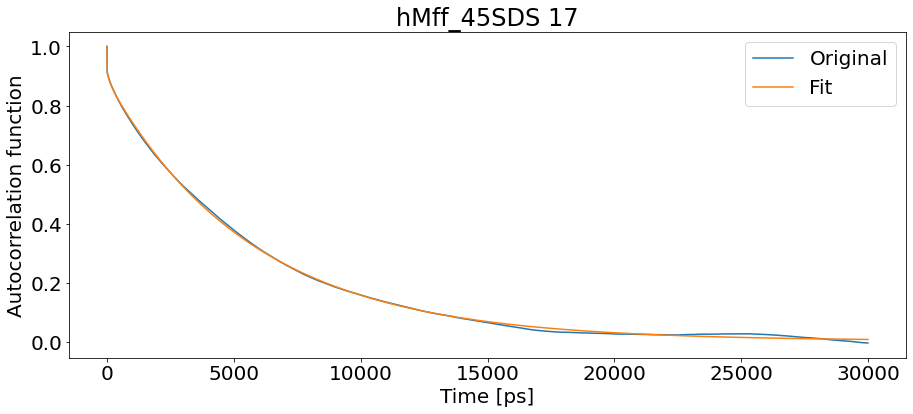

T1: 0.7645242727752994 T2: 0.09329496042877812 NOE: 0.7863803672286052


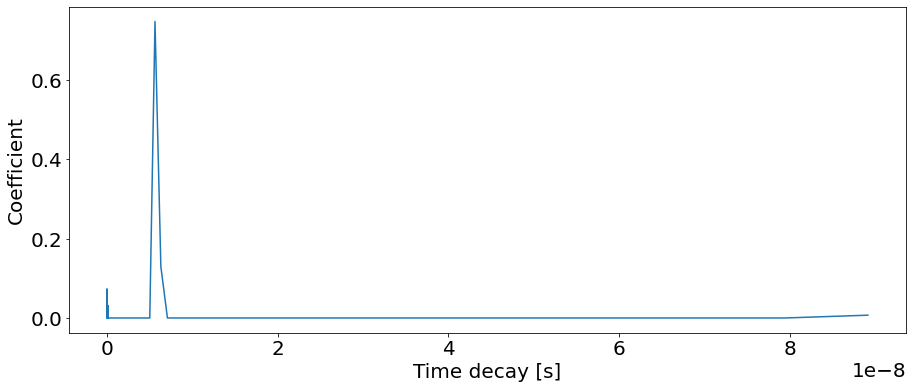

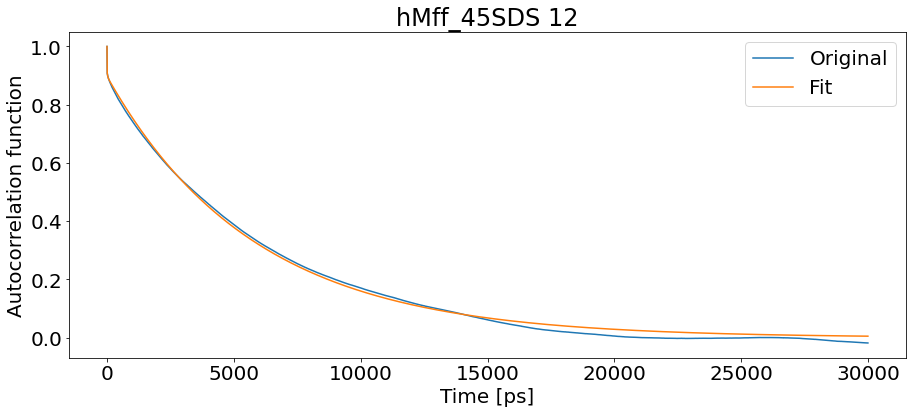

T1: 0.7675847388834586 T2: 0.10084692385536877 NOE: 0.839206640265802


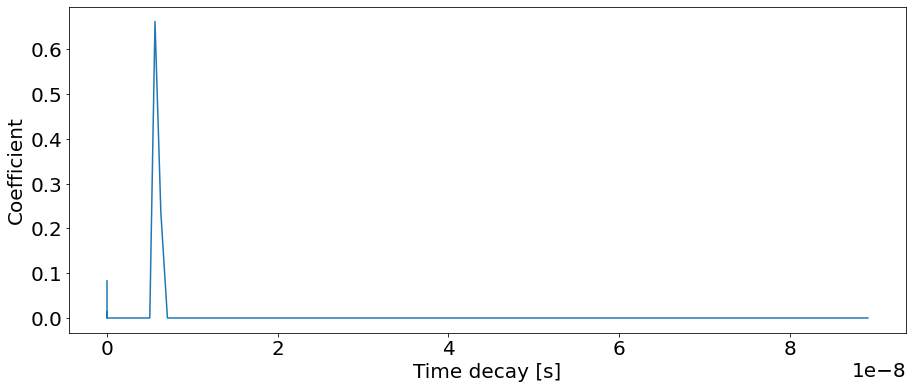

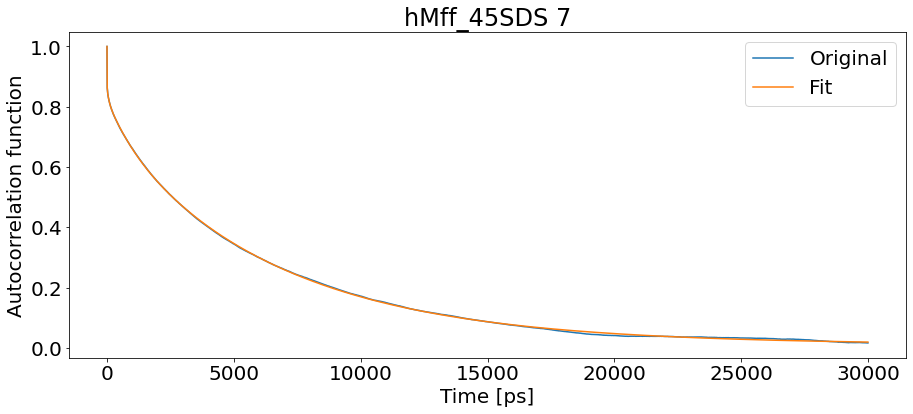

T1: 0.8585150888729413 T2: 0.0849882432677239 NOE: 0.7129992944397223


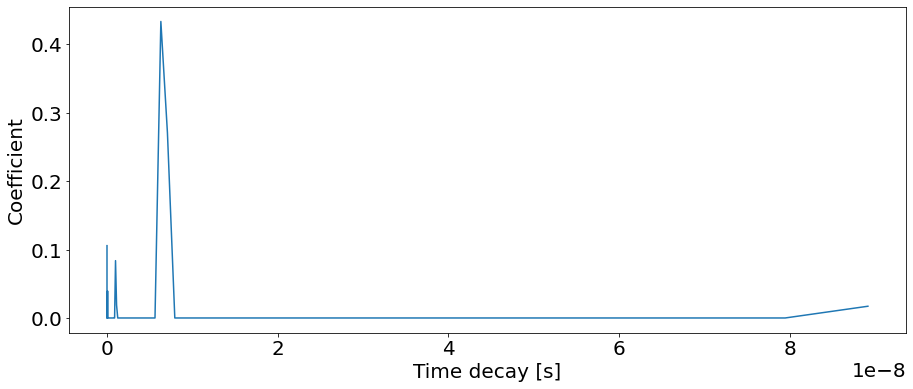

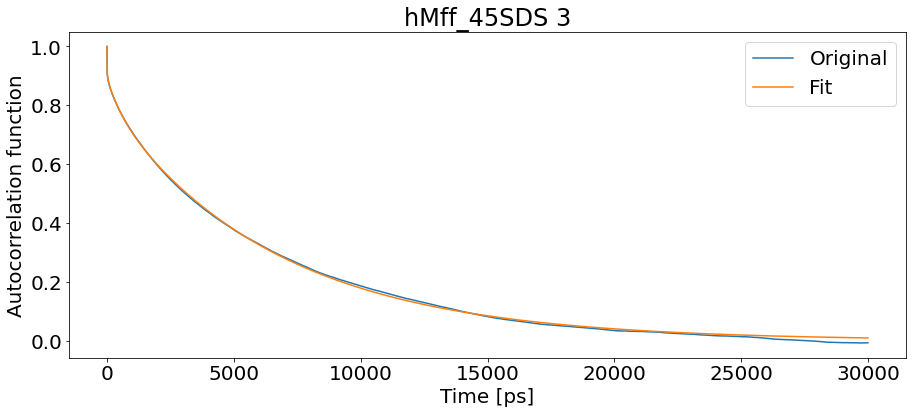

T1: 0.8428230624879247 T2: 0.0981279878381573 NOE: 0.7056957270754756


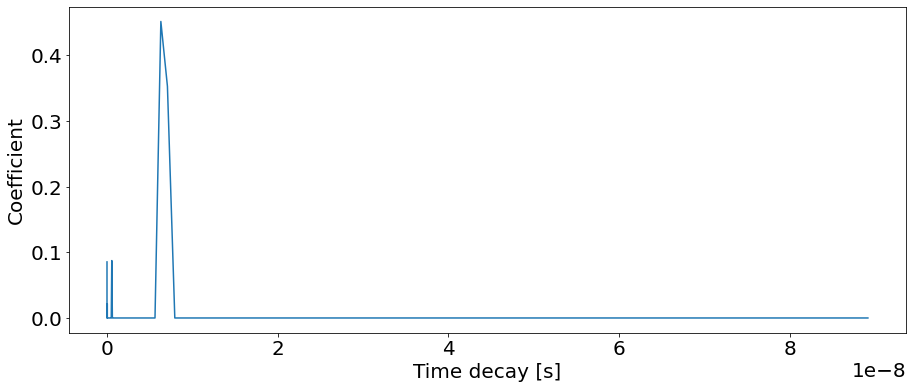

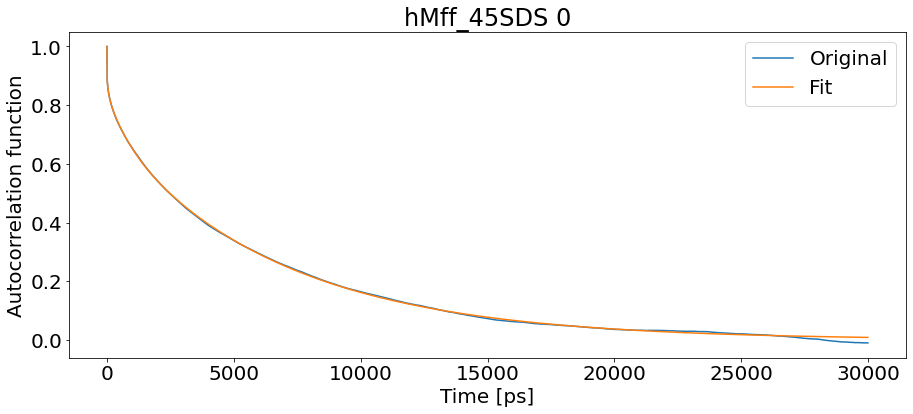

T1: 0.8442741248134519 T2: 0.10696678036594245 NOE: 0.6549990384194222


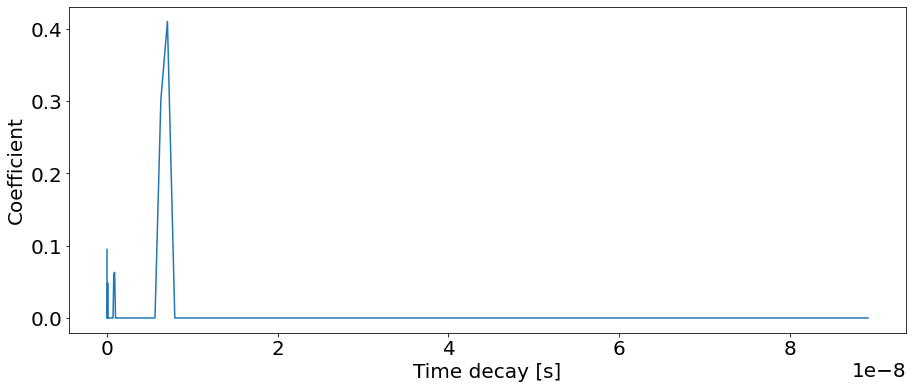

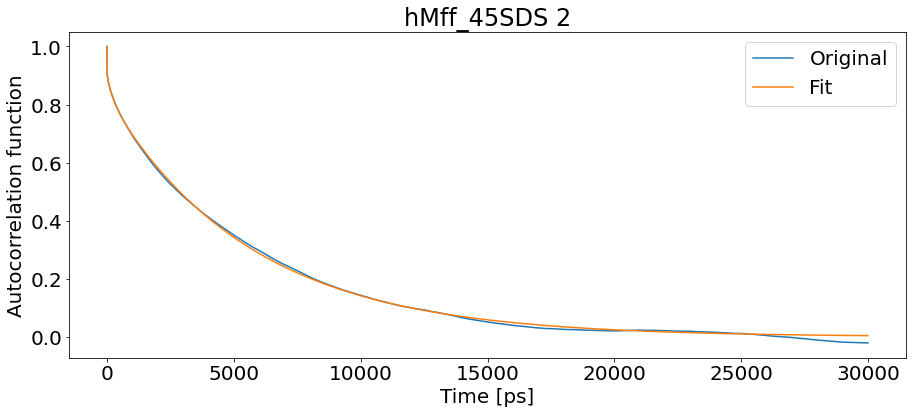

T1: 0.7703068179922343 T2: 0.11060698970761076 NOE: 0.6944207977727739


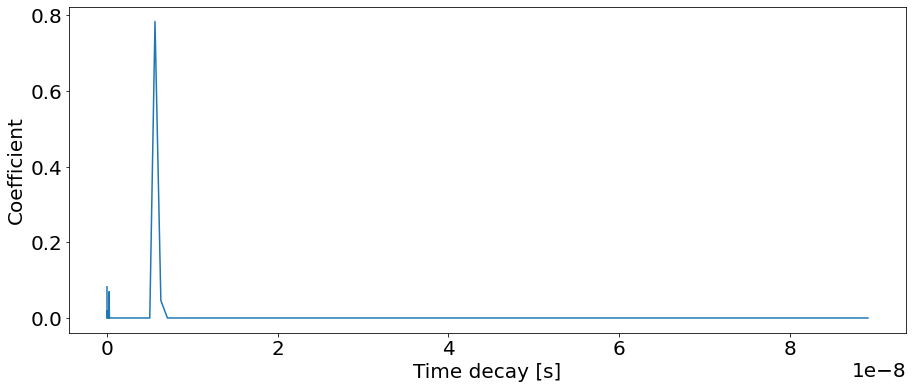

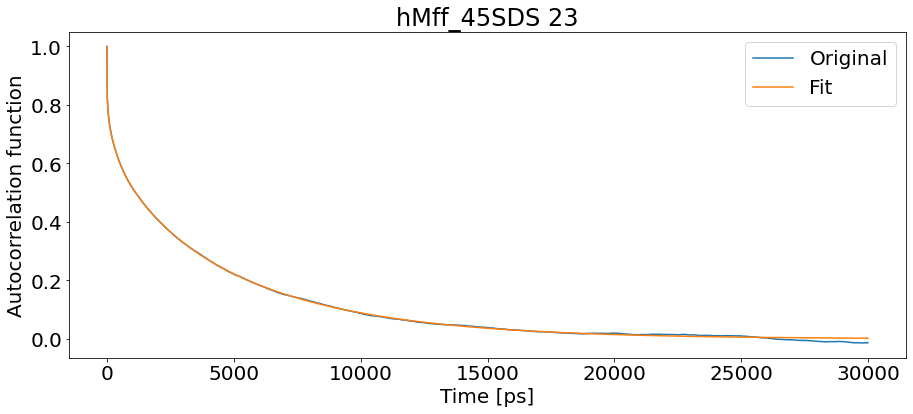

T1: 0.7851297587414209 T2: 0.1566906195564828 NOE: 0.5089460778798024


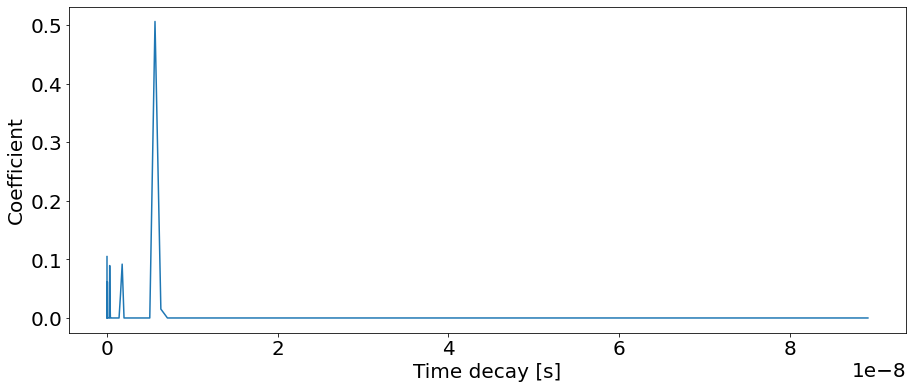

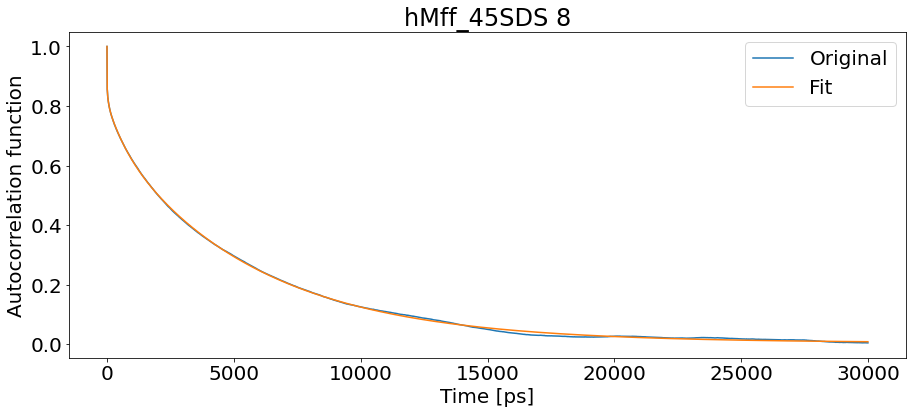

T1: 0.8021360057219622 T2: 0.11215380639931105 NOE: 0.672079007786571


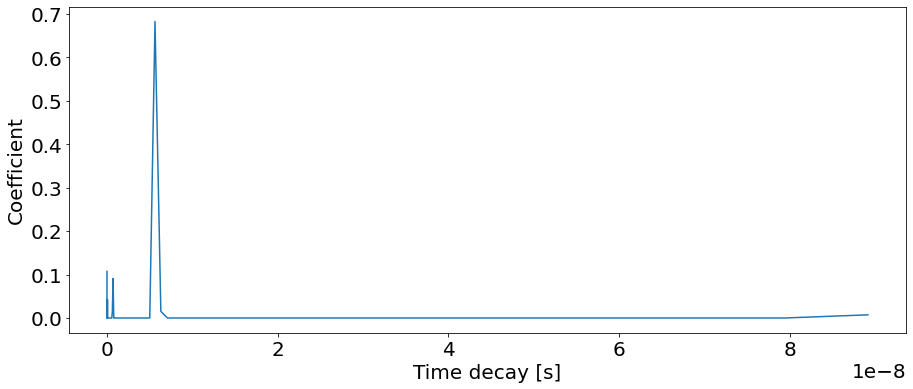

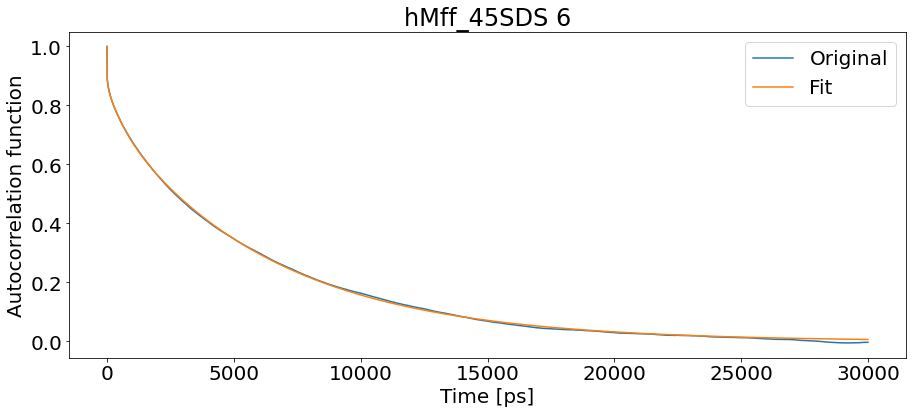

T1: 0.8236321684531182 T2: 0.1069641265055181 NOE: 0.6923770328162344


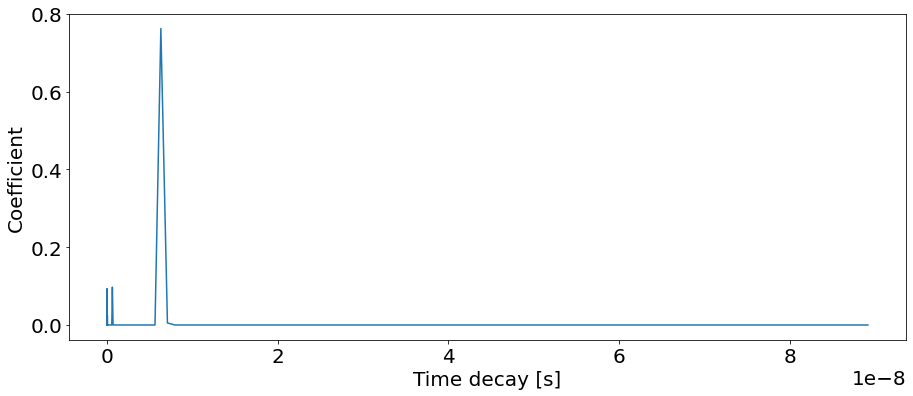

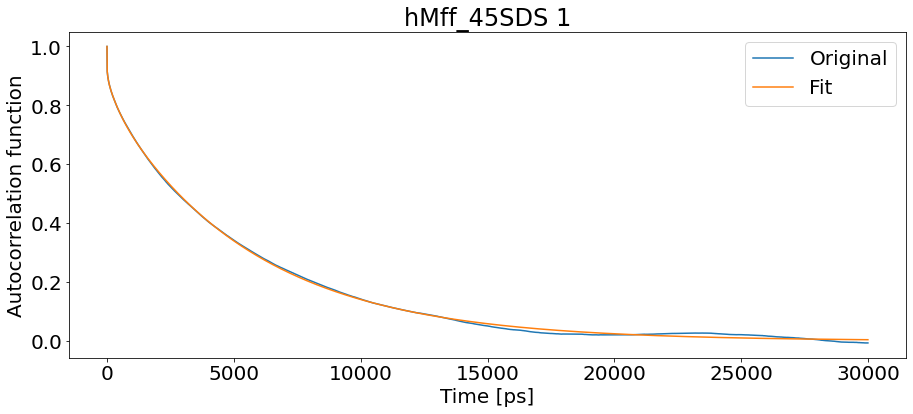

T1: 0.7572848631123493 T2: 0.10724418263908893 NOE: 0.7074806958868353


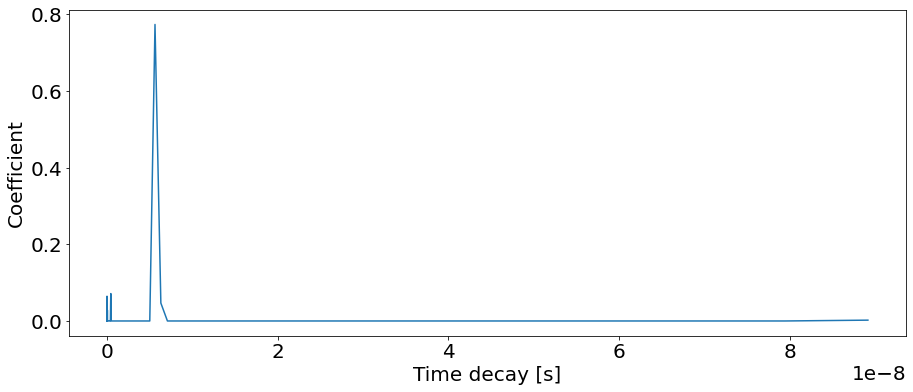

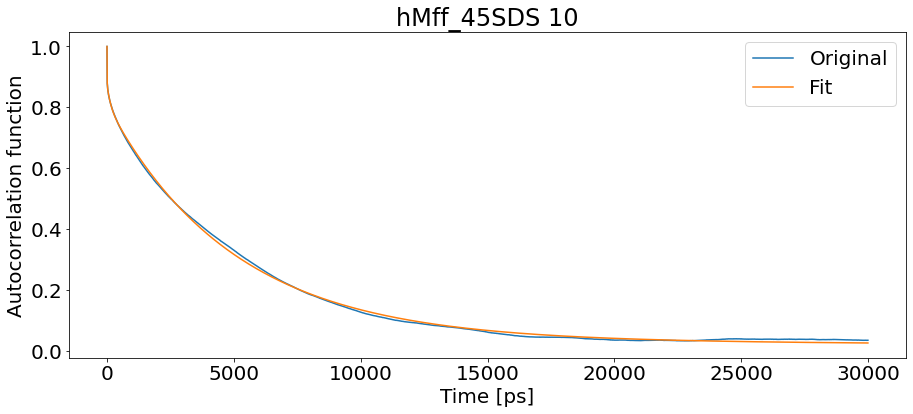

T1: 0.7591723686898227 T2: 0.07724595307460708 NOE: 0.7084743077358779


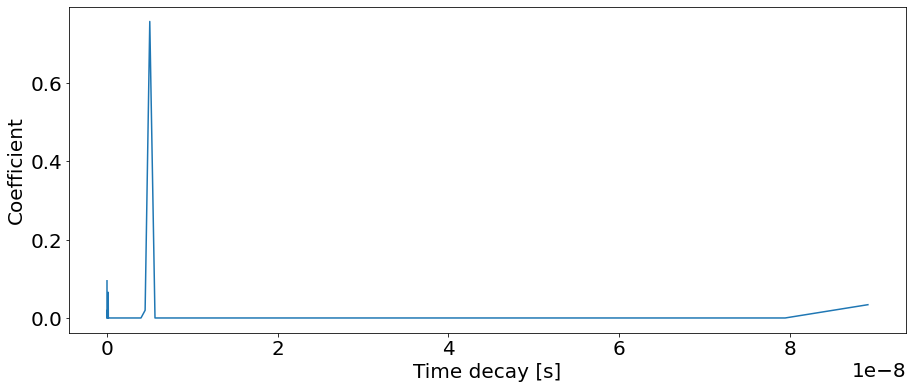

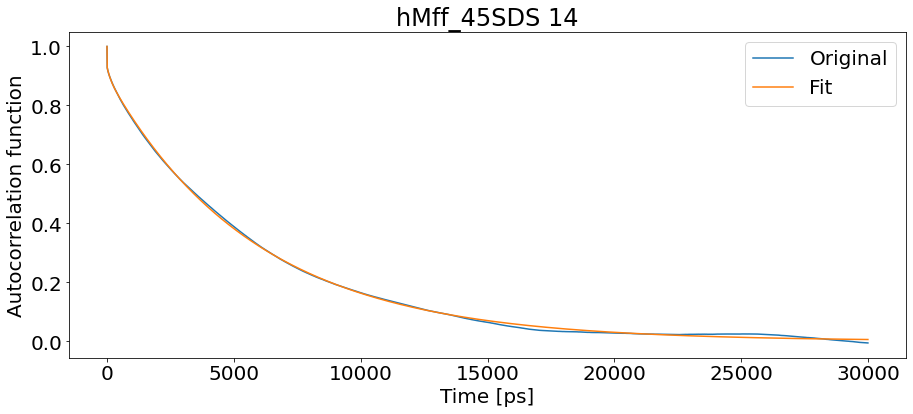

T1: 0.7603257076751028 T2: 0.09722354518946887 NOE: 0.7838770221886986


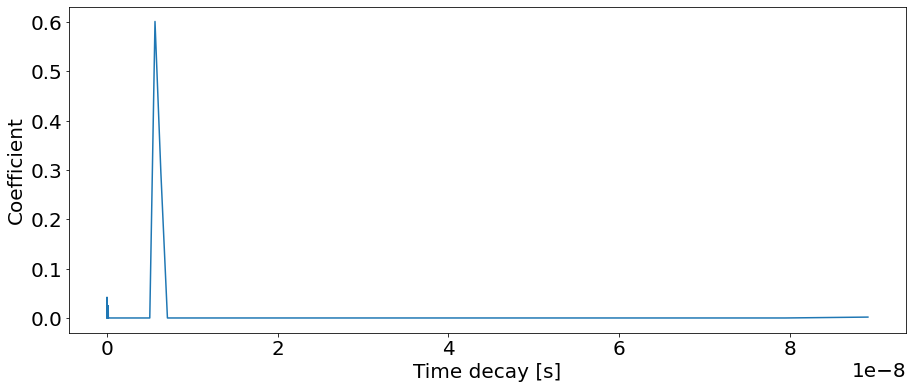

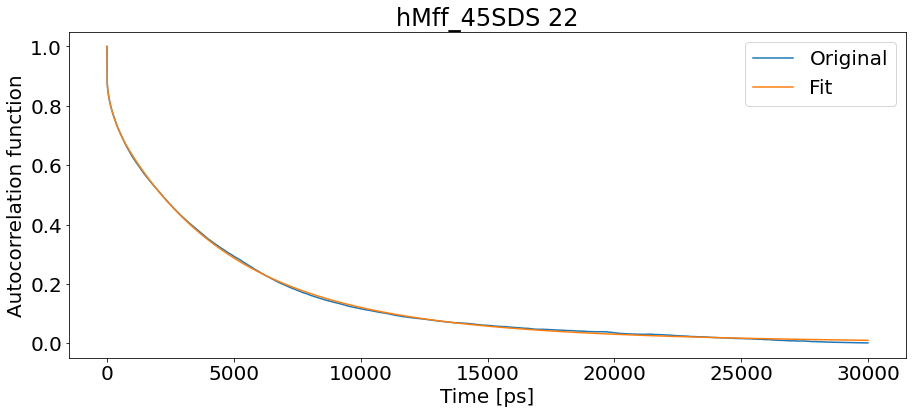

T1: 0.729591306045437 T2: 0.11923644642499535 NOE: 0.6524088689725922


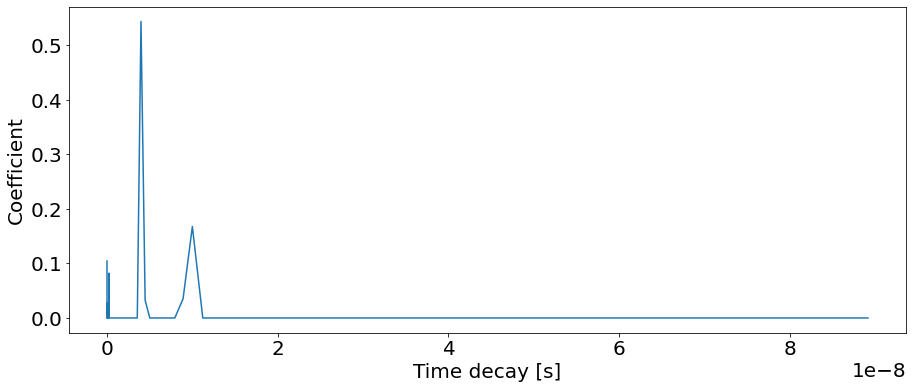

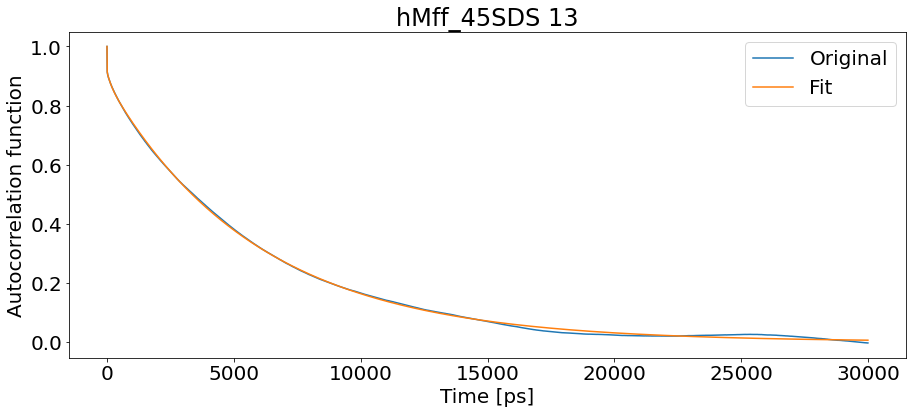

T1: 0.7809896264084956 T2: 0.10053018865035415 NOE: 0.7733306555052634


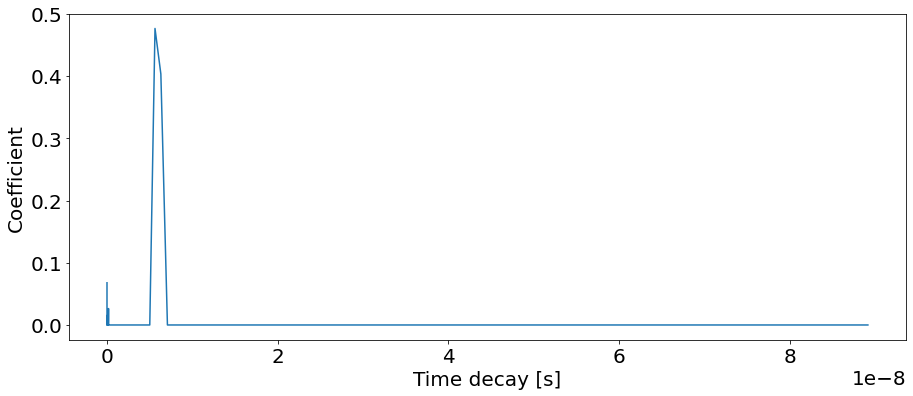

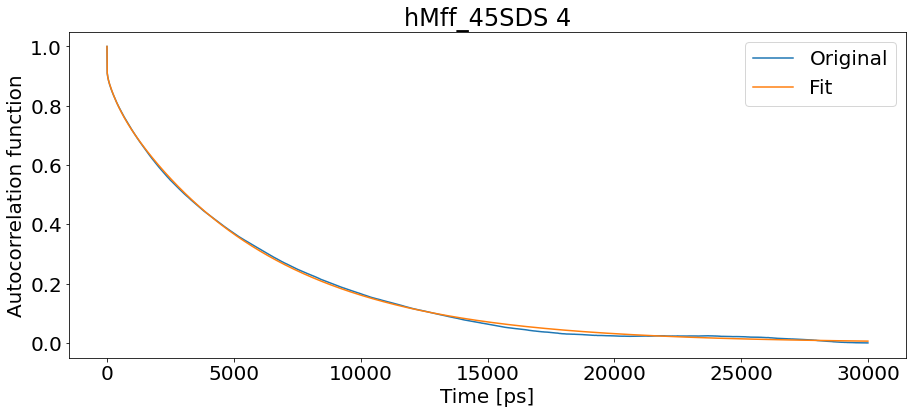

T1: 0.7962953771770853 T2: 0.10275149826062768 NOE: 0.7243771954632827


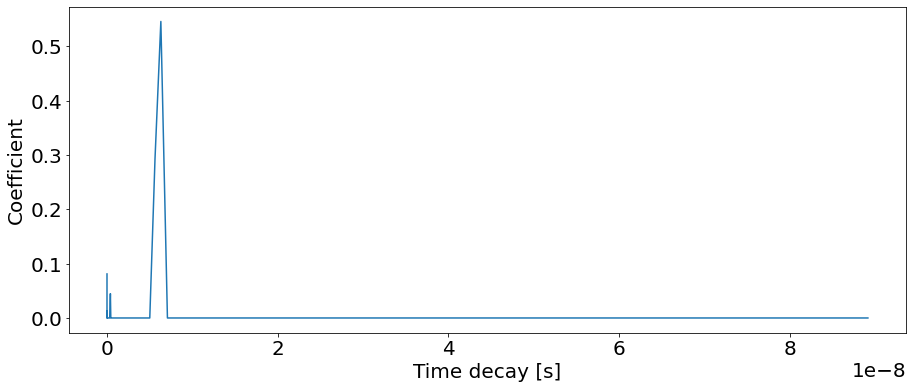

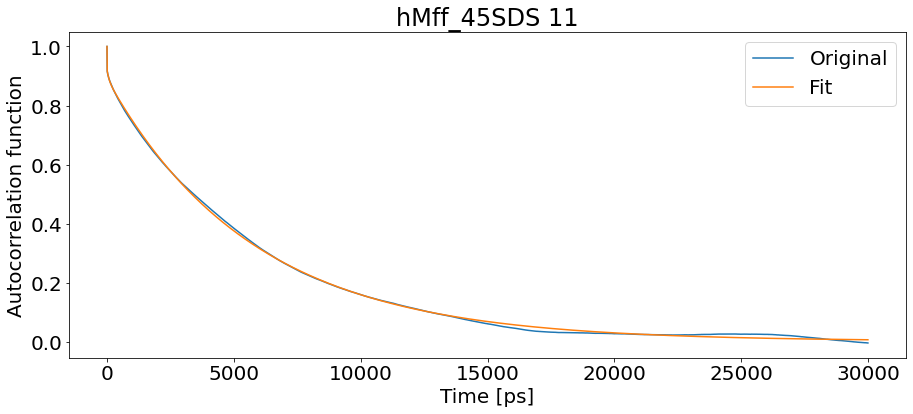

T1: 0.7658376255044791 T2: 0.09661169996959731 NOE: 0.8015927304571474


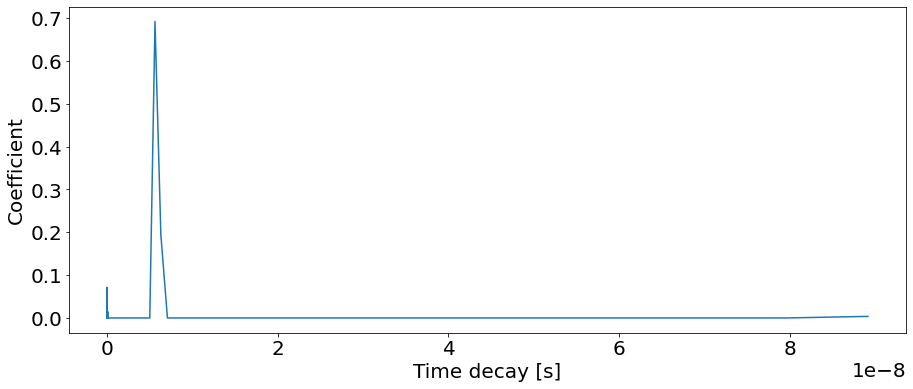

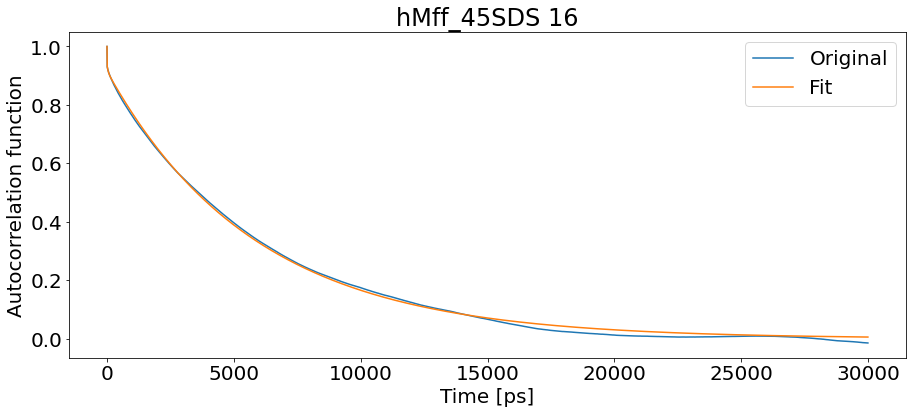

T1: 0.7558581398021703 T2: 0.09812306081769798 NOE: 0.8297705918441898


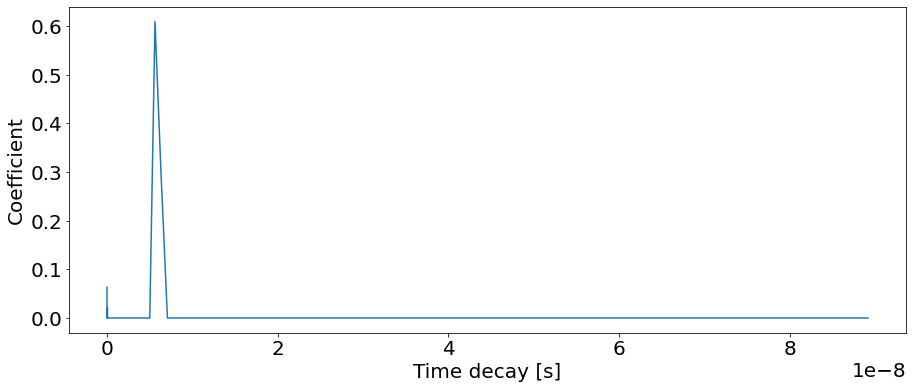

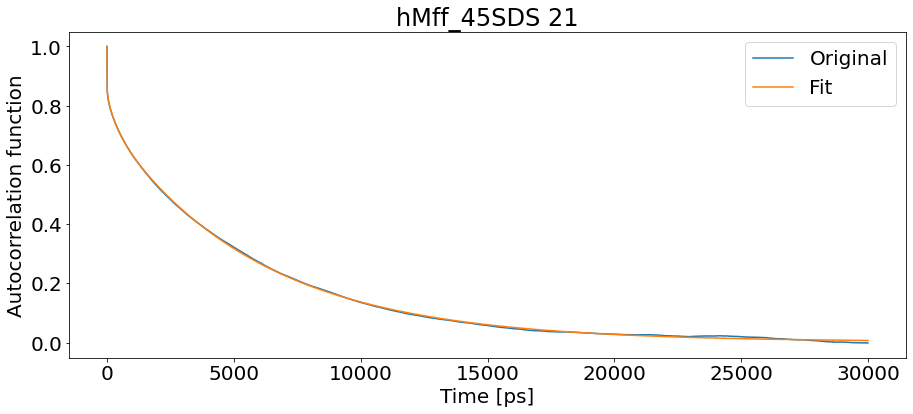

T1: 0.841486869488175 T2: 0.11159621633411566 NOE: 0.653115338579061


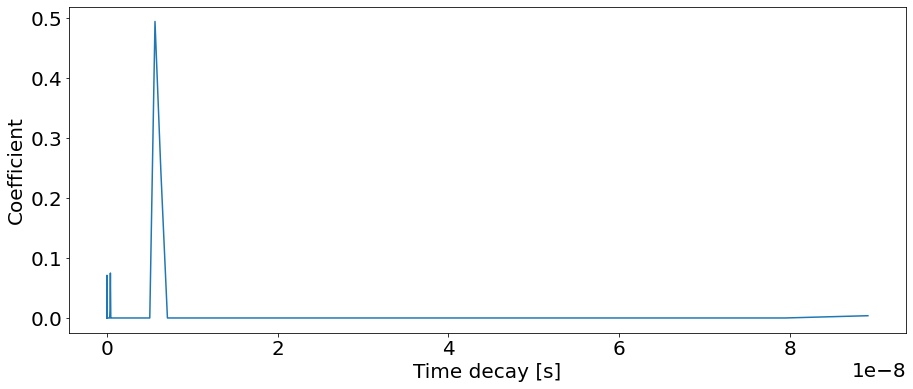

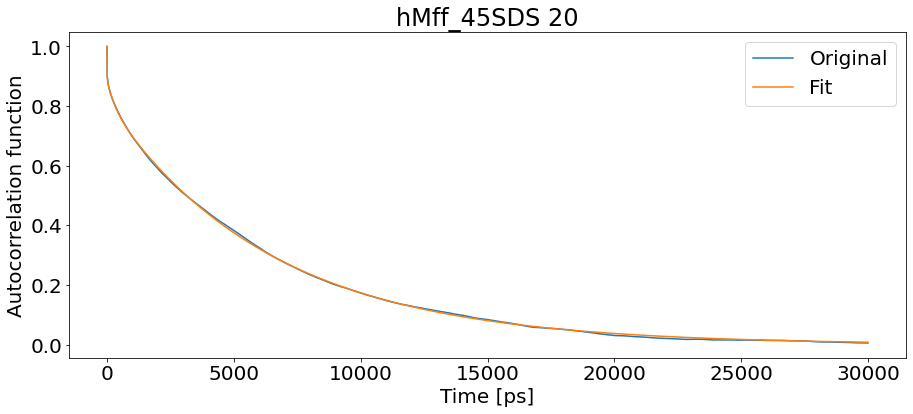

T1: 0.859474958097423 T2: 0.09995038575127604 NOE: 0.6706960964357342


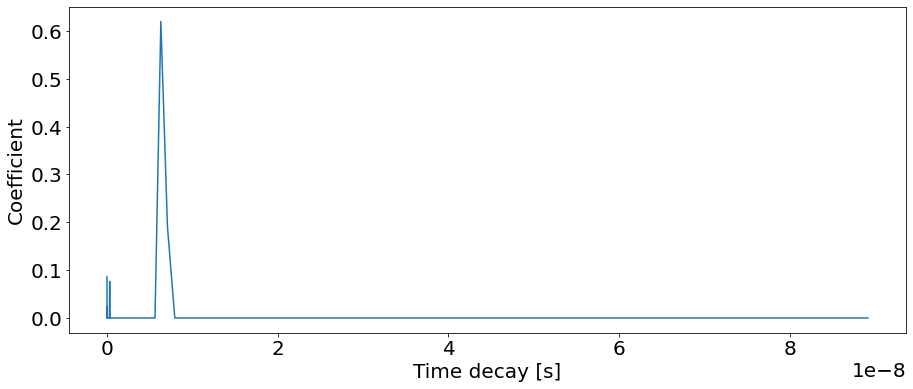

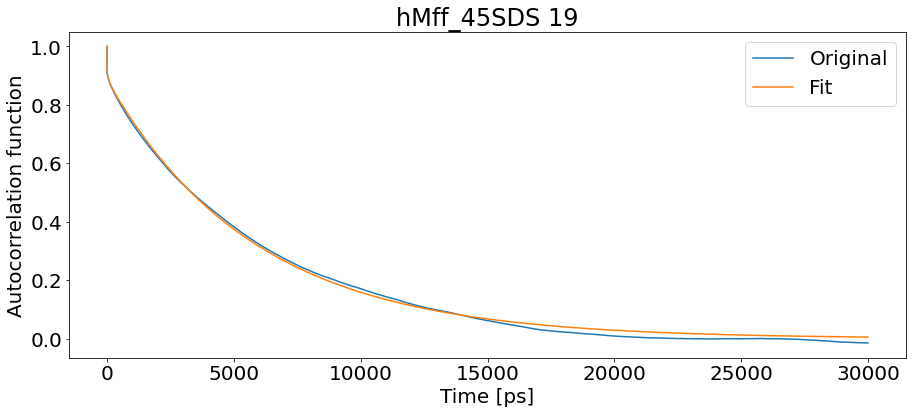

T1: 0.7738400053536338 T2: 0.10187945638403488 NOE: 0.8150104458029279


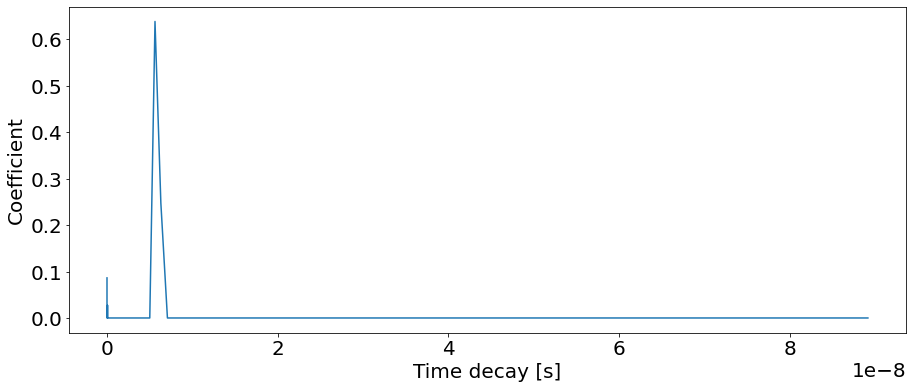

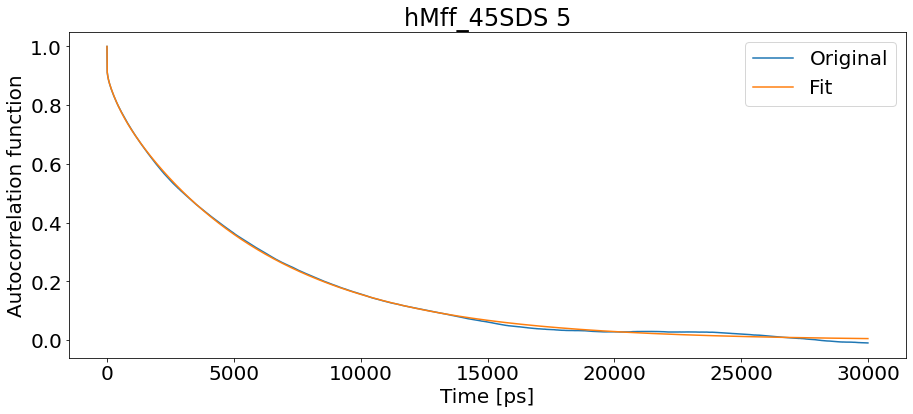

T1: 0.7837810566360012 T2: 0.10460091725163986 NOE: 0.7223102679019904


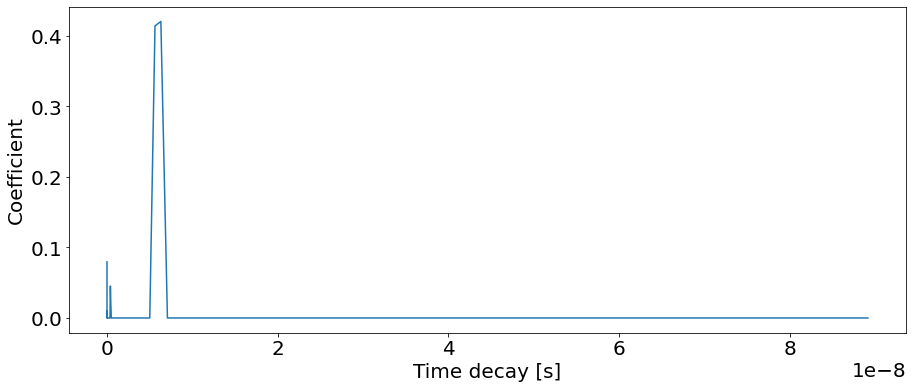

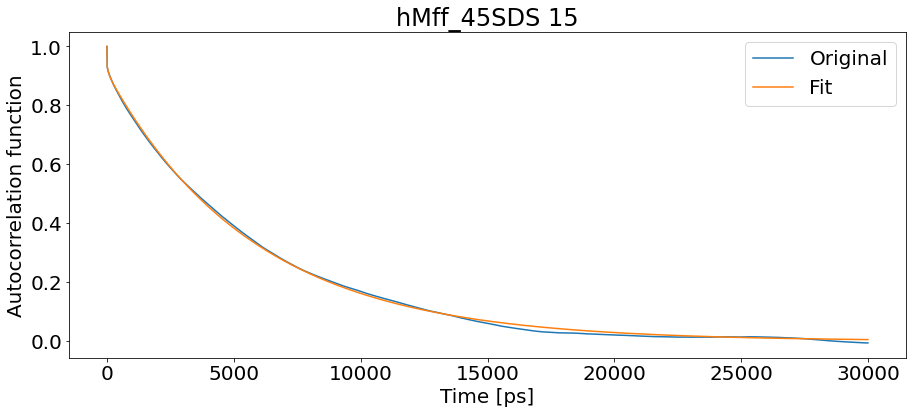

T1: 0.7510153562970694 T2: 0.09950717984769822 NOE: 0.8153577306710063


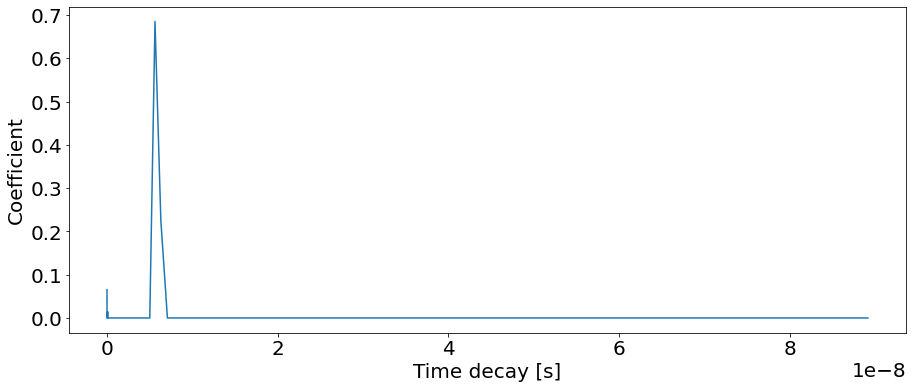

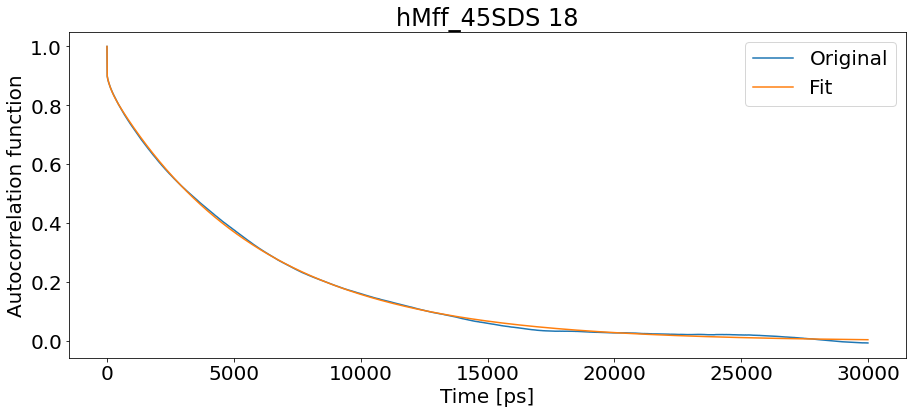

T1: 0.7915166704571394 T2: 0.1025201039762584 NOE: 0.7762138619632182


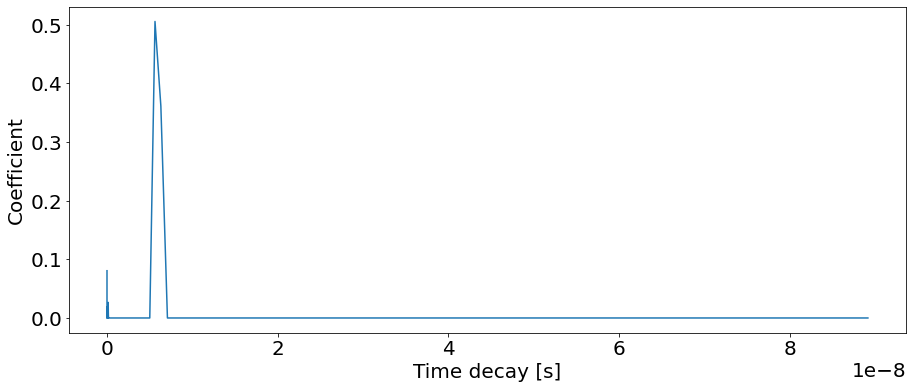

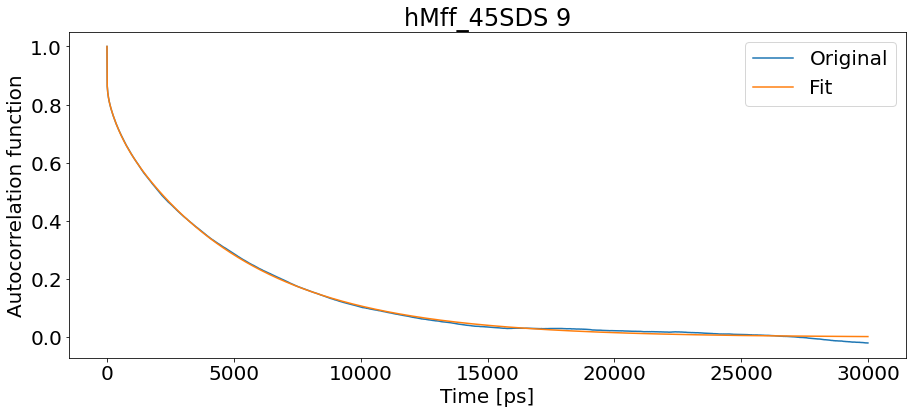

T1: 0.7569263885762436 T2: 0.1312263481119916 NOE: 0.6655578174634127


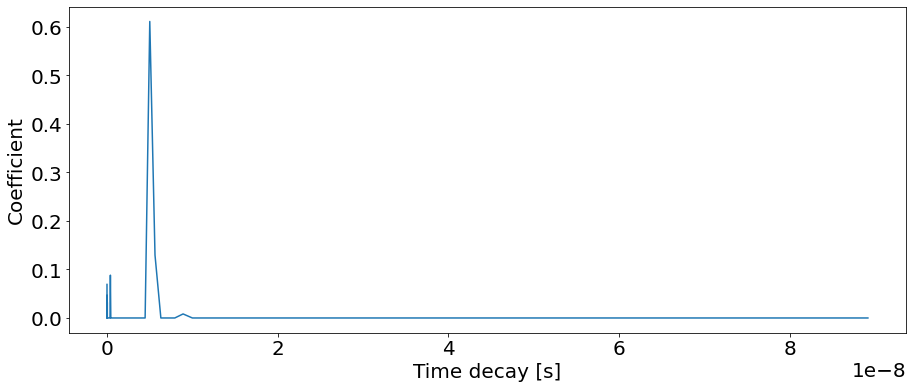

In [4]:
"""Analyze the whole content of a folder"""
aminoAcids=rt.analyze_all_in_folder(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,folder_path,nuclei,output_name)

In [40]:
aminoAcids[17].Coeffs

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01046746, 0.0734098 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03125974, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<h3>4) Plot results</h3>

<h4>4.1) Plot T1, T2, hetNOE relaxation data and saves results to yaml file</h4>

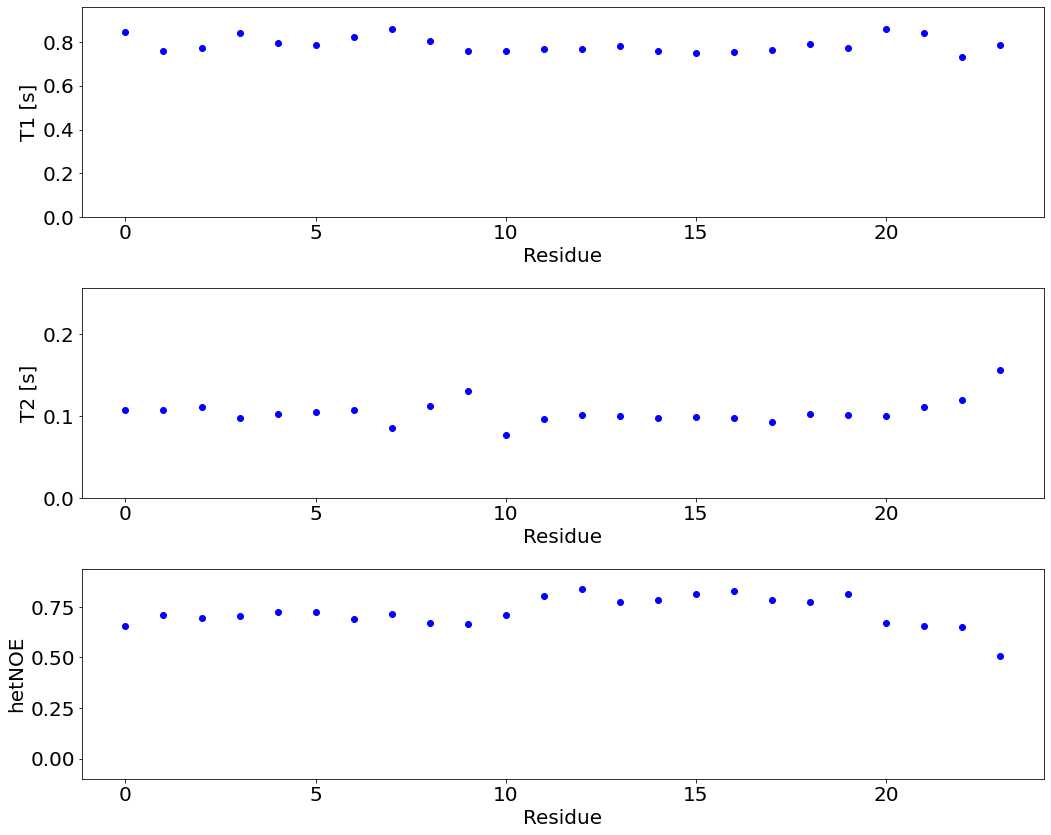

In [5]:
plot_output="relax_times.pdf"
rt.plot_T1_T2_noe(aminoAcids,yaml_output,plot_output)

<h4>4.2) Set y-axis range and categories to plot in different colors</h4>

In [6]:
merge=5 # number of consequent points to be merged (works on log scale!!)
groupTimes=[10**(-10),10**(-9),10**(-9)*5,10**(-8)] # groups points smaller than 1st value, 
                                                    #points between 1st and 2nd, 2nd and 3st....
                                                    #points bigger than the last value
ylim=[10**(-10),10**(-8)*2] # useful for observing details
ylim_weig=[0,1]
#ylim=None # if None the whole range of available data is plotted
title="Time coefficients"
xlabel="Residue of hMff"
plot_output="time_scales.pdf"

<h4>4.2) Plot dynamics</h4>

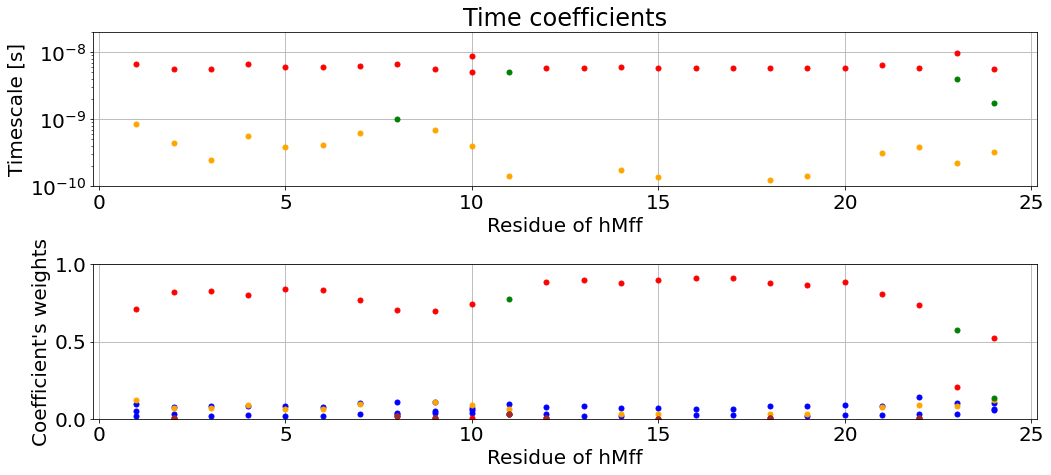

In [7]:
rt.PlotTimescales(aminoAcids,merge,groupTimes,title,xlabel,ylim,ylim_weig,plot_output)

<h3>Save data into simple text file</h3>

In [34]:
text_output=output_path+output_name+".txt"
with open(yaml_output) as f:
    data_to_save=yaml.load(f,Loader=yaml.FullLoader)

with open(text_output,"w") as f:
    f.write("# Author: "+author_name+"\n # system: "+output_name+"\n")
    f.write("# residue      T1                 T2                  hetNOE \n")
    for residue in data_to_save:
        f.write("   "+ str(residue)+"         "+str(float(data_to_save[residue]["T1"]))+" "+
                str(float(data_to_save[residue]["T2"]))+" "+
                str(float(data_to_save[residue]["hetNOE"]))+"\n")

<center><h1>Spin relaxation times as a function of field and dynamics</h1></center>

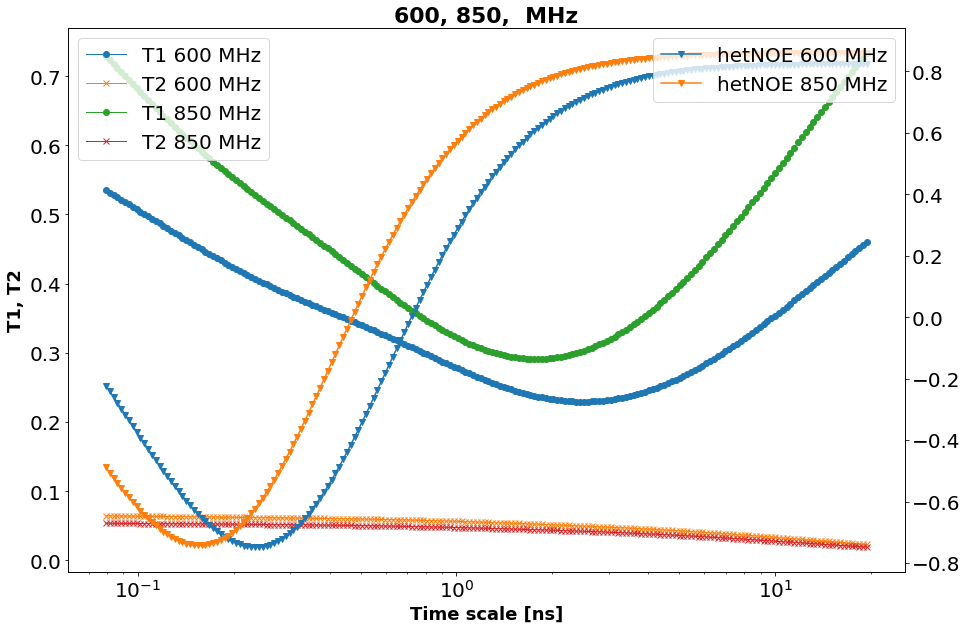

In [260]:
#plot relaxation times as a function of dynamics and magnetic field, only 2D plot, atm
magnetic_fields=[600,850]


smallest_corr_time=1.9 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=4.3 # same as above
N_exp_to_fit=200 # number of exponential functions to be fitted between the samlles and biggest corr time

step_exp=(biggest_corr_time-smallest_corr_time)/N_exp_to_fit
Ctimes = 10 ** np.arange(smallest_corr_time, biggest_corr_time, step_exp)
Ctimes = Ctimes * 0.001 * 10 ** (-9);

fig,ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel("Time scale [ns]",fontsize=18, weight = 'bold')
ax.set_ylabel("T1, T2",fontsize=18, weight = 'bold')
ax.set_xscale('log')
ax2.set_ylabel("hetNOE",fontsize=18, weight = 'bold')
ax2.set_xscale('log')
ax2=ax.twinx()

title=""
for magn_field in magnetic_fields:
    magnetic_field=magn_field*2*np.pi/gammaH*10**6
    
    T1=[]
    T2=[]
    NOE=[]
    for time_scale in Ctimes:
        t1, t2, noe = rt.get_relaxation_N(magnetic_field,[1,1],[time_scale,10**-8],OP)
        T1.append(t1)
        T2.append(t2)
        NOE.append(noe)
        
    
    ax.plot(Ctimes*10**9,T1,label="T1 " + str(magn_field)+ " MHz",  marker="o", linewidth=1.0)
    ax.plot(Ctimes*10**9,T2,label="T2 " + str(magn_field)+ " MHz",   marker="x", linewidth=1.0)
    
    
    ax2.plot(Ctimes*10**9,NOE,label="hetNOE " + str(magn_field)+ " MHz",marker="v")
    title+= str(magn_field) + ", "
    

ax.set_title(str(title)+ " MHz",fontsize=22, weight = 'bold')
ax2.legend(loc='upper right')

ax.legend(loc='upper left')
plt.show()